In [1]:
# SOURCE CODE: https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter04/ch4_nb2_reuse_models_from_keras_apps.ipynb
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
import keras
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
import warnings
warnings.filterwarnings("ignore")

# Choosing which GPU this notebook can access
# (useful when running multiple experiments in parallel, on different GPUs):
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

# Some hyper-parameters:
input_shape = [224, 224, 3] # We will resize the input images to this shape
batch_size  = 32            # Images per batch (reduce/increase according to the machine's capability)
num_epochs  = 300           # Max number of training epochs
random_seed = 42            # Seed for some random operations, for reproducibility

In [2]:
#SOURCE DATA: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data
#number of chest Xrays in train folder: 1341 normal, 3875 pneumonia
#number of chest Xrays in test folder: 234 normal, 390 pneumonia

#INSTRUCTIONS UPLOADING KAGGLE DATASET TO GOOGLE COLAB: https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/
!pip install opendatasets
!pip install pandas
import opendatasets as od
import pandas
od.download(
    "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ws912345
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:21<00:00, 115MB/s]


In [3]:
# Number of classes:
num_classes = 2
class_names = ['NORMAL', 'PNEUMONIA']
# Number of images:
num_train_imgs = 1341 + 3875
num_val_imgs = 234 + 390
#SOURCE CODE FOR TRAIN STEPS CALCULATIONS: https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter04/ch4_nb2_reuse_models_from_keras_apps.ipynb
train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(num_val_imgs / batch_size)

In [4]:
#CODE HELP SOURCE FROM TENSORFLOW DOCUMENTATION: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
# CODE HELP SOURCE FROM TENSORFLOW DOCUMENTATION: https://www.tensorflow.org/tutorials/load_data/images
#MAKING THE TrainING SET
#in this project we focus on using the dataset from chest-xray train which is further subdivided into 0.2-0.8 split of training and testing
#Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/chest-xray-pneumonia/chest_xray/train/",
  labels='inferred',
  validation_split=0.2,
  subset="training",
  seed=random_seed,
  image_size=(224, 224),
  batch_size=batch_size, shuffle=True,
    )

Found 5216 files belonging to 2 classes.
Using 4173 files for training.


In [5]:
#CODE HELP SOURCE FROM TENSORFLOW DOCUMENTATION: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
# https://www.tensorflow.org/tutorials/load_data/images
#in this project we focus on using the dataset from chest-xray train which is further subdivided into 0.2-0.8 split of training and testing
#Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).
test_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/chest-xray-pneumonia/chest_xray/train/",
  labels='inferred',
  validation_split=0.2,
  subset="validation",
  seed=random_seed,
  image_size=(224, 224),
  batch_size=batch_size, shuffle=True,
    )

Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


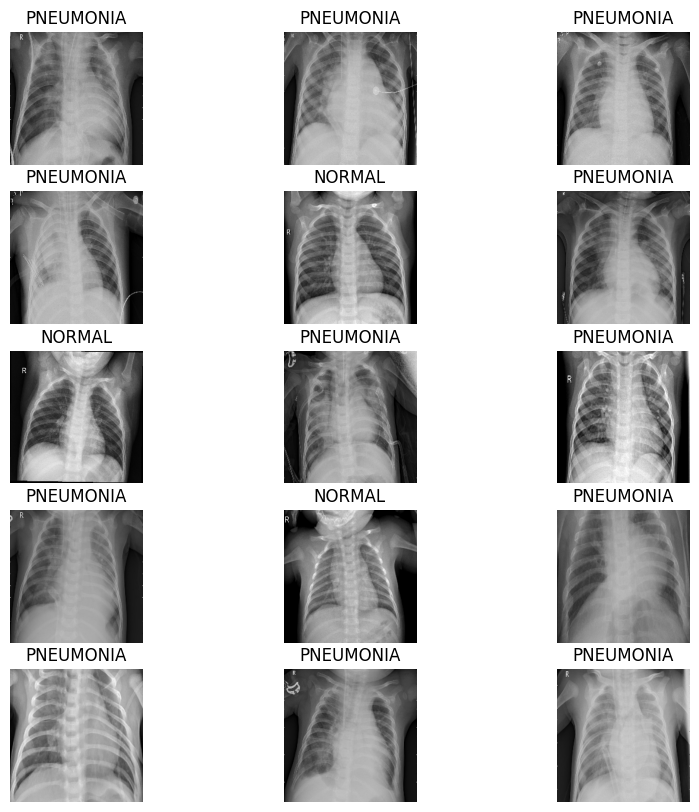

In [6]:
#SOURCE CODE FOR PLOTTING: https://www.tensorflow.org/tutorials/load_data/images
#visualizing first nine images from the training set
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
#INITIATE RESNET
#source code: https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/9a73003eff274f288d59dfb1532a5a48655bfaa3/Chapter04/ch4_nb1_implement_resnet_from_scratch.ipynb
model1 = tf.keras.applications.resnet50.ResNet50(
    include_top=True, weights=None,
    input_shape=input_shape, classes=num_classes)
model = tf.keras.applications.vgg16.VGG16(
    include_top=True, weights=None,
    input_shape=input_shape, classes=num_classes)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
#standardizing the data
#standardize RGB channels from [0,255] to [0,1]
#source: https://www.tensorflow.org/tutorials/load_data/images
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [9]:
#configure dataset for performance
#prevent I/O blocking when calling data from disk
#code source: https://www.tensorflow.org/tutorials/load_data/images
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
#apply training now to the data using the model, use Adam optimizer and Sparse Categorical Cross Entropy for loss function, add some metrics of performance
#SOURCE CODE: https://www.tensorflow.org/tutorials/load_data/images
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [11]:
x_s=[]
y_s=[]
for feature, label in test_ds:
  x_s.append(feature)
  y_s.append(label)
x_s=x_s[:-1]
y_s=y_s[:-1]

In [ ]:
model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=3
)

Epoch 1/3
116/131 [=========================>....] - ETA: 16:26 - loss: 63.3068 - accuracy: 0.7314

ValueError: ignored